In [1]:
!pip freeze
!pip3 install numpy
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install pydotplus
!pip3 install six

absl-py==1.2.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.7
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2022.2.0
datascience==0.17.5
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.

Problem 1: The American Job

1. Bad data

In [25]:
import pandas as pd

df = pd.read_csv('https://gist.githubusercontent.com/inumanag/713fb4367cacfeab82b07104482e73a7/raw/76a7ab7503476ce8f6a25269dc2755c13bbf5c36/elections.csv')
df = df.apply(pd.to_numeric, errors='coerce')

nan_val = df.isna().values.sum()
print('Not a number values: ',nan_val)

df = df.fillna(0)

Not a number values:  5


2. Split

In [3]:
# encoding tip from: https://stackoverflow.com/questions/61264795/pandas-unicodedecodeerror-utf-8-codec-cant-decode-bytes-in-position-0-1-in
# was getting unicode error otherwise
df2 = pd.read_csv('https://raw.githubusercontent.com/kjhealy/us-county/master/data/census/fips-by-state.csv', encoding = 'unicode_escape', engine = 'python')

df2.rename(columns = {'fips':'FIPS', 'state':'STATE', 'name':'COUNTY'}, inplace = True)
df = pd.merge(df, df2, on="FIPS", how="inner")
del df['FIPS']

3. Aggregate

Aggregate Education

In [4]:
ed_col = ['PERCENT OF ADULTS WITH LESS THAN A HIGH SCHOOL DIPLOMA,', 
                     'PERCENT OF ADULTS WITH A HIGH SCHOOL DIPLOMA ONLY,',
                     "PERCENT OF ADULTS COMPLETING SOME COLLEGE OR ASSOCIATE'S DEGREE,",
                     "PERCENT OF ADULTS WITH A BACHELOR'S DEGREE OR HIGHER,"]

def aggEd(row):
  col_val_dict = {'LT High School': row[ed_col[0]], 
                'High School': row[ed_col[1]], 
                'Some College': row[ed_col[2]],
                "GTE Bachelor's": row[ed_col[3]]}
  # help from https://stackoverflow.com/questions/65328275/find-key-in-dictionary-with-n-th-largest-value
  sort = sorted(col_val_dict.items(), key = lambda item: item[1], reverse = True)
  highest = sort[2][0]
  return highest

# help from https://towardsdatascience.com/create-new-column-based-on-other-columns-pandas-5586d87de73d
df['EDUCATION'] = df.apply(lambda row: aggEd(row), axis=1)

Aggregate Religion

In [5]:
rel_col = ['AMISH', 'BUDDHIST', 'CATHOLIC',
       'CHRISTIAN GENERIC', 'EASTERN ORTHODOX', 'HINDU', 'JEWISH',
       'MAINLINE CHRISTIAN', 'MORMON', 'MUSLIM', 'NON-CATHOLIC CHRISTIAN',
       'OTHER', 'OTHER CHRISTIAN', 'OTHER MISC', 'PENTECOSTAL / CHARISMATIC',
       'PROTESTANT DENOMINATION', 'ZOROASTRIAN',]

rel_df = df[rel_col].copy()

def nthHighest(row, n):
  ''' Takes a row and number n, and returns the row name with the nth highest value '''
  temp_dict = row.to_dict()
  sort = sorted(temp_dict.items(), key = lambda item: item[1], reverse = True)
  highest = sort[n-1][0]
  return highest

df['RELIGION'] = rel_df.apply(lambda row: nthHighest(row, 3), axis=1)

Aggregate Age

In [6]:
age_col = ['0-4 RATE', '5-9 RATE', '10-14 RATE', '15-19 RATE', '20-24 RATE',
       '25-29 RATE', '30-34 RATE', '35-39 RATE', '40-44 RATE', '45-49 RATE',
       '50-54 RATE', '55-59 RATE', '60-64 RATE', '65-69 RATE', '70-74 RATE',
       '75-79 RATE', '80-84 RATE', '85+ RATE']

df['AGE OLD'] = df['55-59 RATE'] + df['60-64 RATE'] + df['65-69 RATE'] +\
                df['70-74 RATE'] + df['80-84 RATE'] + df['85+ RATE']
df['AGE YOUNG'] = df['0-4 RATE'] + df['5-9 RATE'] + df['10-14 RATE'] +\
                  df['15-19 RATE'] + df['20-24 RATE']
df['AGE ADULT'] = df['25-29 RATE'] + df['30-34 RATE'] + df['35-39 RATE'] +\
                  df['40-44 RATE'] + df['45-49 RATE'] + df['50-54 RATE']

Aggregate Ethnicity

In [7]:
eth_f_col = ['WHITE FEMALE RATE', 'BLACK FEMALE RATE',
       'NATIVE AMERICAN FEMALE RATE', 'ASIAN FEMALE RATE',
       'HAWAIIAN PACIFIC FEMALE RATE','MULTI FEMALE RATE',]
eth_m_col = ['WHITE MALE RATE', 'BLACK MALE RATE',
             'NATIVE AMERICAN MALE RATE', 'ASIAN MALE RATE',
             'HAWAIIAN PACIFIC MALE RATE', 'MULTI MALE RATE',]
non_mf_ethnic_columns = ['BLACK RATE', 'WHITE RATE',
       'NATIVE AMERICAN RATE', 'HAWAIIAN PACIFIC RATE', 'MULTI RATE',]

eth_f_df = df[eth_f_col].copy()
eth_m_df = df[eth_m_col].copy()

eth_f_df.columns = eth_f_df.columns.str.replace('FEMALE RATE', '')
eth_m_df.columns = eth_m_df.columns.str.replace('MALE RATE', '')

df['ETHNIC MALE'] = eth_m_df.apply(lambda row: nthHighest(row, 2), axis=1)
df['ETHNIC FEMALE'] = eth_f_df.apply(lambda row: nthHighest(row, 2), axis=1)

Clean-up

In [8]:
del df['POVERTY UNDER 18 PCT']
del df['HOUSING UNITS']
del df['DENSITY PER SQUARE MILE OF LAND AREA - HOUSING UNITS']
del df['DENSITY PER SQUARE MILE OF LAND AREA - POPULATION']
del df['AGE TOTAL POP']
del df['AREA IN SQUARE MILES - LAND AREA']
del df['AREA IN SQUARE MILES - WATER AREA']
df = df.drop(
    ed_col + rel_col + age_col + eth_f_col + eth_m_col + non_mf_ethnic_columns,
    axis = 1,
)

df.rename(columns = {'AREA IN SQUARE MILES - TOTAL AREA':'AREA IN SQUARE MILES'}, inplace=True)

4. Rename

In [9]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' rate', '')
df.columns = df.columns.str.replace(' ', '_')

5. Normalize

In [10]:
# help from https://www.geeksforgeeks.org/data-normalization-with-pandas/#:~:text=The%20z-score%20method%20%28often%20called%20standardization%29%20transforms%20the,feature%20then%20dividing%20by%20the%20quality%20deviation.%20Python3
def zNormalize(column):
  ''' z-score normalizes a column '''
  return (column - column.mean()) / column.std()

df['population'] = zNormalize(df['population'])
df['area_in_square_miles'] = zNormalize(df['area_in_square_miles'])
df['per_capita_inc'] = zNormalize(df['per_capita_inc'])
df['pop_estimate'] = zNormalize(df['pop_estimate'])
df['tot_male'] = zNormalize(df['tot_male'])
df['tot_female'] = zNormalize(df['tot_female'])

In [11]:
df['poverty_all_ages_pct'] = df['poverty_all_ages_pct']/100
df['deep_pov_all'] = df['deep_pov_all']/100
df['deep_pov_children'] = df['deep_pov_children']/100
df['unemployment'] = df['unemployment']/100

6. Summary

In [12]:
df.columns

Index(['votes', 'unemployment', 'pop_estimate', 'med_hhinc', 'per_capita_inc',
       'poverty_all_ages_pct', 'deep_pov_all', 'deep_pov_children',
       'population', 'area_in_square_miles', 'tot_male', 'tot_female',
       'voter_turnout', 'democrat', 'county', 'state', 'education', 'religion',
       'age_old', 'age_young', 'age_adult', 'ethnic_male', 'ethnic_female'],
      dtype='object')

Population info

In [13]:
print('pop_estimate stats:')
print('name:',df.pop_estimate.name)
print('mean:',df.pop_estimate.mean())
print('std:',df.pop_estimate.std())

print('\npopulation stats:')
print('name:',df.population.name)
print('mean:',df.population.mean())
print('std:',df.population.std())

cor_score = df.pop_estimate.corr(df.population)

print('\ncorrelation:',cor_score)

if(cor_score > 0.9):
  del df['pop_estimate']

pop_estimate stats:
name: pop_estimate
mean: 3.394312431975001e-18
std: 0.9999999999999999

population stats:
name: population
mean: 2.2628749546500005e-18
std: 1.0

correlation: 0.9974332586878153


Voter turnout and unemployment info

In [14]:
print('voter_turnout stats:')
print('name:',df.voter_turnout.name)
print('median:',df.voter_turnout.median())

vq1 = df.voter_turnout.quantile(0.25)
vq3 = df.voter_turnout.quantile(0.75)
print('quartiles:',vq1,vq3)
print('IQR:',vq3-vq1)

print('\nunemployment stats:')
print('name:',df.unemployment.name)
print('median:',df.unemployment.median())

uq1 = df.unemployment.quantile(0.25)
uq3 = df.unemployment.quantile(0.75)
print('quartiles:',uq1,uq3)
print('IQR:',uq3-uq1)

voter_turnout stats:
name: voter_turnout
median: 0.437952565
quartiles: 0.38483760175 0.4916421425
IQR: 0.10680454075000001

unemployment stats:
name: unemployment
median: 0.053
quartiles: 0.042 0.065
IQR: 0.023


Mode of religion and ethnic_female

In [15]:
print('religion mode:',df.religion.mode().values[0])
print('ethnic female mode:',df.ethnic_female.mode().values[0])

religion mode: MAINLINE CHRISTIAN
ethnic female mode: BLACK 


7. Visualize

Histograms of religion, ethnic_male, ethnic_female, and education

In [16]:
# help from https://plotly.com/python/histograms/#:~:text=Histograms%20on%20Categorical%20Data%201%20Histograms%20in%20Dash,than%20count%20...%207%20Visualizing%20the%20distribution%20
import plotly.express as px
fig = px.histogram(df, x="religion")
fig.show()

In [17]:
fig2 = px.histogram(df, x='ethnic_male')
fig2.show()

In [18]:
fig3 = px.histogram(df, x='ethnic_female')
fig3.show()

In [19]:
fig4 = px.histogram(df, x='education')
fig4.show()

Scatter plot of area and population.

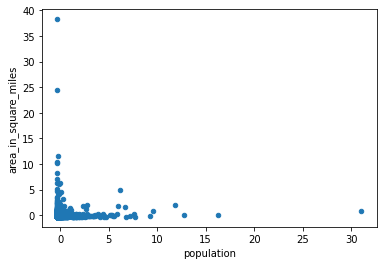

In [20]:
df.plot(x='population', y='area_in_square_miles', kind='scatter')

Box plot of normalized voter_turnout and unemployment

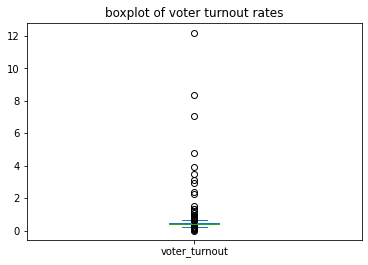

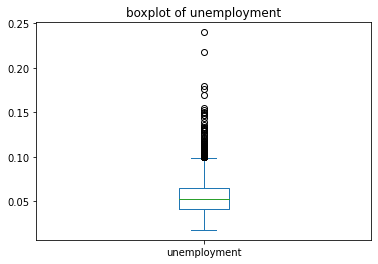

In [21]:
df[['voter_turnout']].plot(kind='box', title='boxplot of voter turnout rates')
df[['unemployment']].plot(kind='box', title='boxplot of unemployment')

8. Conflict

All total conflicting percentage instances can be found by running the below code.

In [22]:
conflict = df.voter_turnout.between(1, 10, inclusive='both').values.sum()
if(conflict>0):
  print('instances where voter turnout is greater than 100%:', conflict)

conflict = df.unemployment.between(1, 10, inclusive='both').values.sum()
if(conflict>0):
  print('instances where unemployment rate is greater than 100%:', conflict)

conflict = df.poverty_all_ages_pct.between(1, 10, inclusive='both').values.sum()
if(conflict>0):
  print('instances where poverty all ages rate is greater than 100%:', conflict)

conflict = df.deep_pov_all.between(1, 10, inclusive='both').values.sum()
if(conflict>0):
  print('instances where deep poverty all rate is greater than 100%:', conflict)

conflict = df.deep_pov_children.between(1, 10, inclusive='both').values.sum()
if(conflict>0):
  print('instances where deep poverty children rate is greater than 100%:', conflict)

instances where voter turnout is greater than 100%: 14


9. Labels

In [23]:
print(df.columns)

Index(['votes', 'unemployment', 'med_hhinc', 'per_capita_inc',
       'poverty_all_ages_pct', 'deep_pov_all', 'deep_pov_children',
       'population', 'area_in_square_miles', 'tot_male', 'tot_female',
       'voter_turnout', 'democrat', 'county', 'state', 'education', 'religion',
       'age_old', 'age_young', 'age_adult', 'ethnic_male', 'ethnic_female'],
      dtype='object')


Based off the features above, I believe democrat is the label vector. Since all the rest are information about the most 2nd or 3rd most common groups in the area, we are wanting to predict whether the elected candidate is democrat or republican.

Save dataframe to csv.

In [24]:
df.to_csv("elections_clean.csv", index=False)